Using Financial-year overruns: mean=28.24% | sd=64.67%

RQ1: Sample risk drivers (first 5 projects)
 - Geological Disposal Facility Programme (GDF): ['planning delays', 'technical challenges']
 - Green Homes Grant: Local Authority Delivery (LAD): ['procurement risk']
 - Help to Grow - Management: ['funding issues', 'procurement risk']
 - Home Upgrade Grant (HUG) Phase 1: ['procurement risk']
 - Local Authority Delivery (LAD) Phase 3: ['procurement risk']

RQ2: Model setup
- Baseline Duration (CPM on mode durations): 86.2 months
- Baseline Cost: £2550.826086956522m
- Driver-based multipliers (cost): {'Planning': 1.022, 'Design': 1.022, 'Permitting': 1.0, 'Construction': 1.019, 'Testing': 1.138}


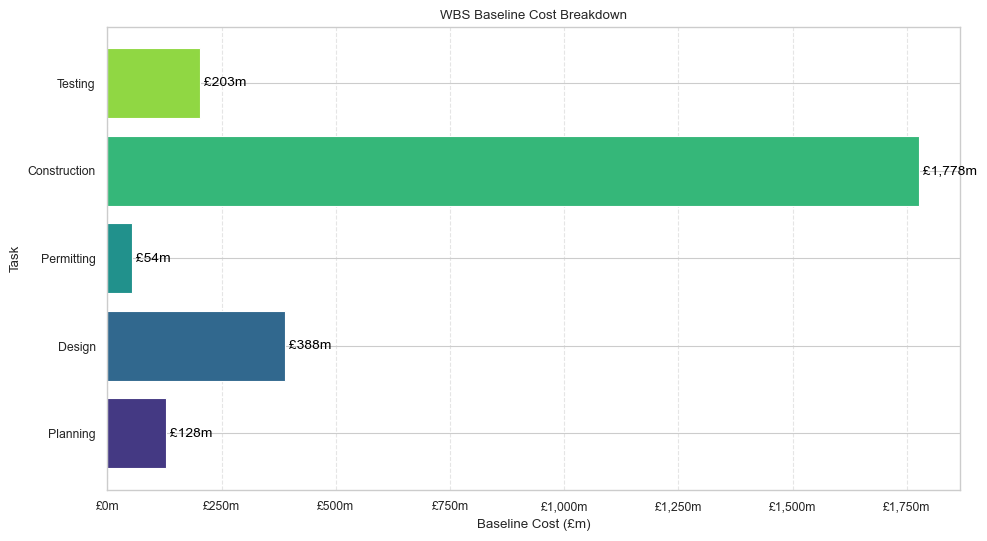

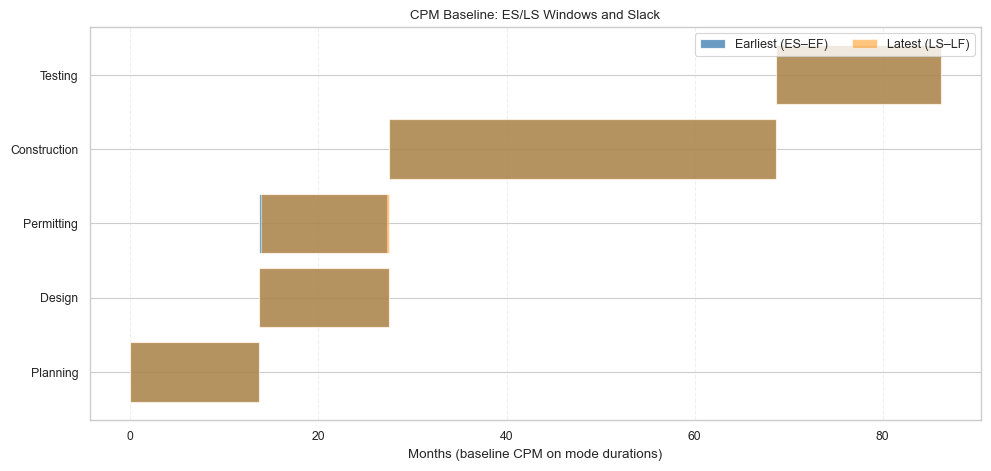

[Saved] simulated_durations.csv and simulated_costs.csv

Criticality Index (CPM) — Tasks:
 - Planning: 87.5%
 - Design: 52.3%
 - Permitting: 50.2%
 - Construction: 87.5%
 - Testing: 87.5%

Criticality Index (CPM) — Edges:
 - Planning → Design: 52.3%
 - Planning → Permitting: 50.2%
 - Design → Construction: 52.3%
 - Permitting → Construction: 50.2%
 - Construction → Testing: 87.5%

RQ3: Likelihood of overruns
- Mean Duration: 104.77 months | P90: 239.38 | Prob delay: 48.79%
- Mean Cost: £21681.81m | P90: £52428.47m | Prob overrun: 53.77%
- Prob(cost overrun >20%): 51.71%
- Prob(cost overrun >50%): 48.83%
- Prob(schedule delay >20%): 41.96%
- Prob(schedule delay >50%): 33.07%


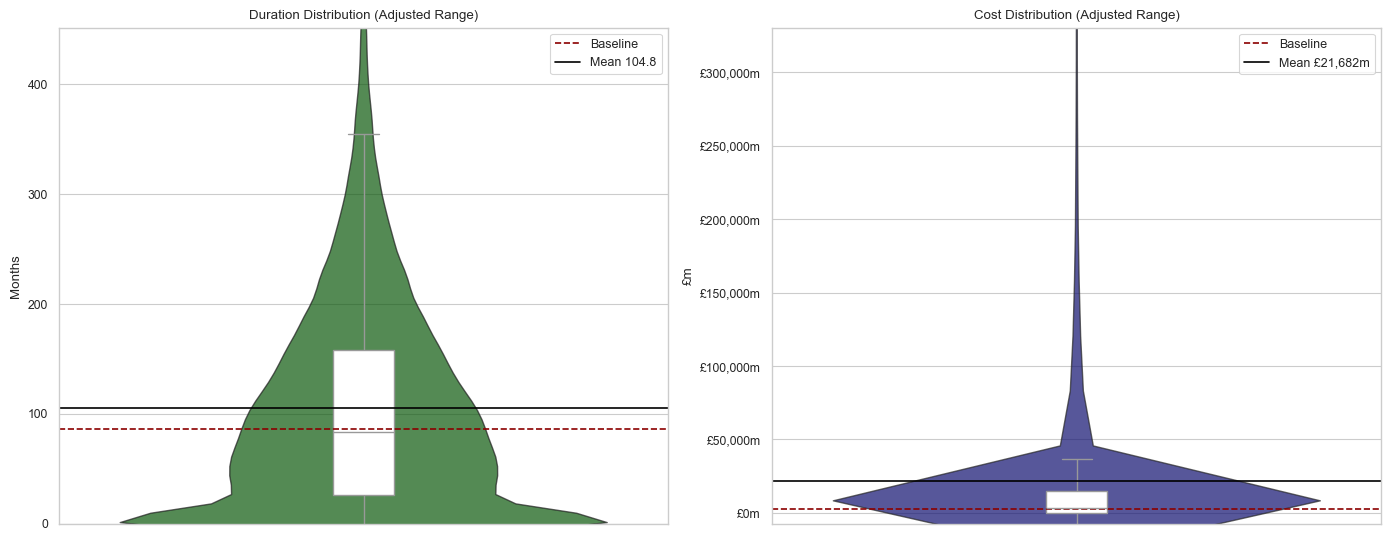

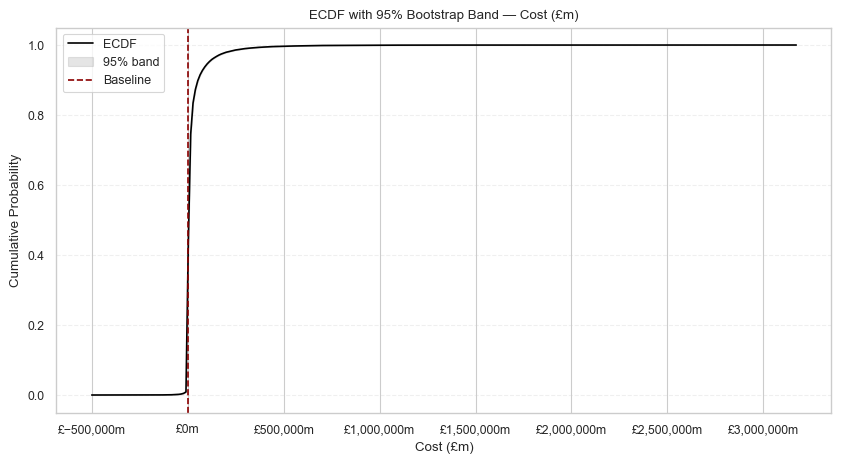

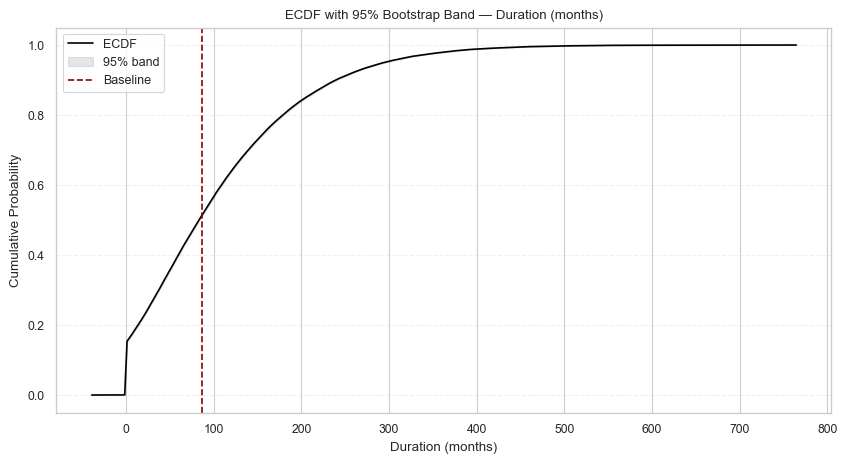

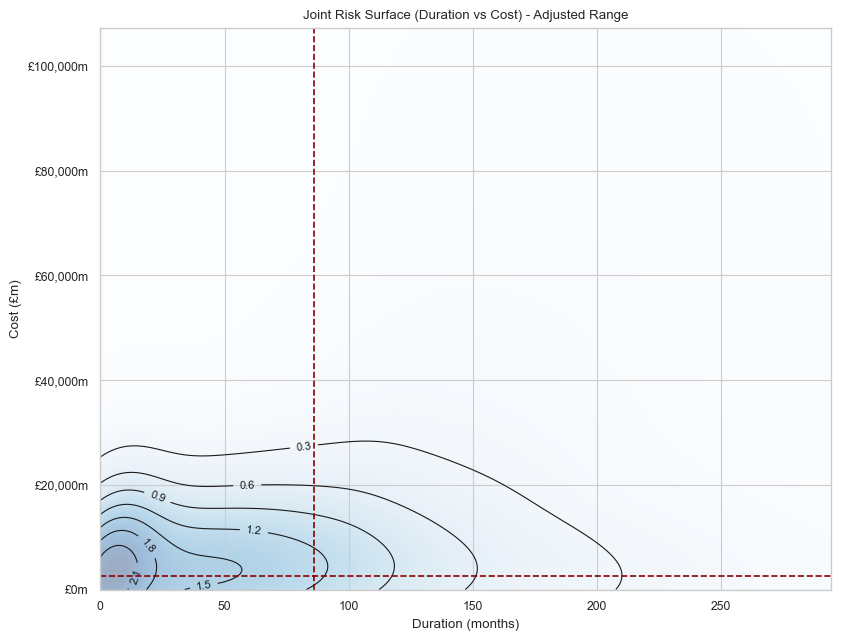

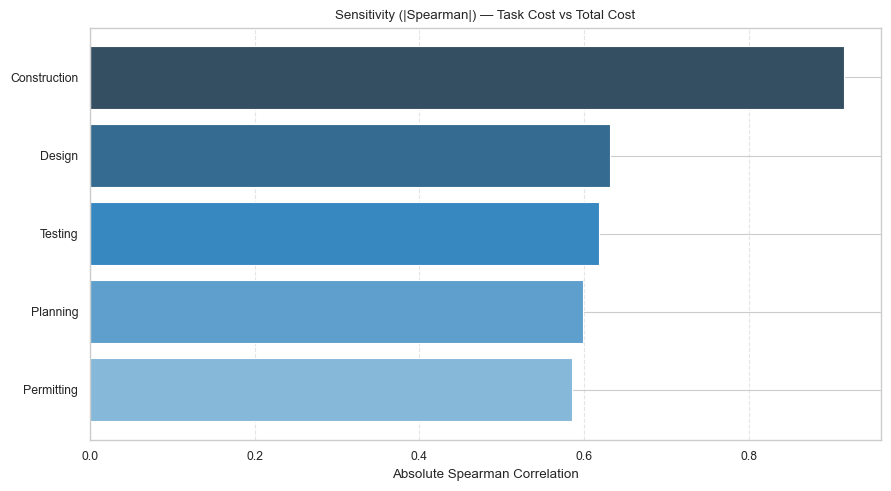

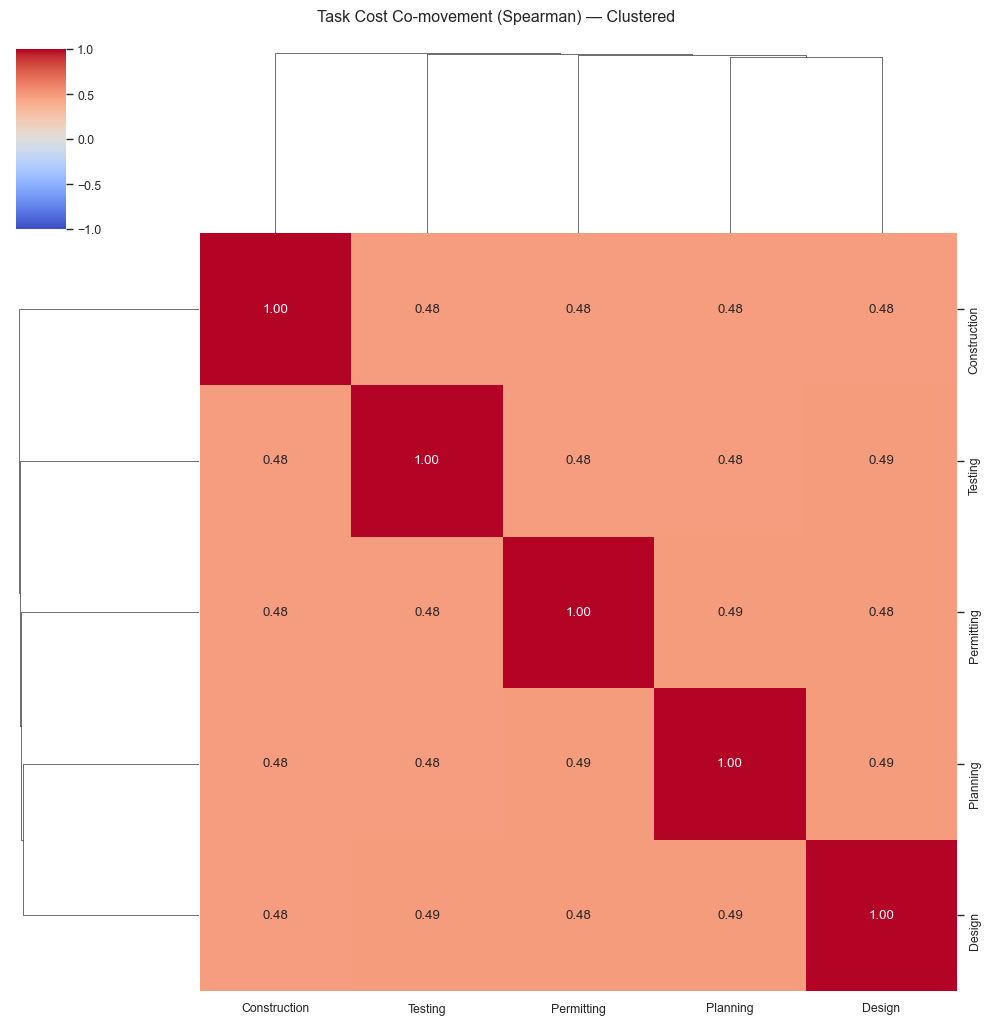

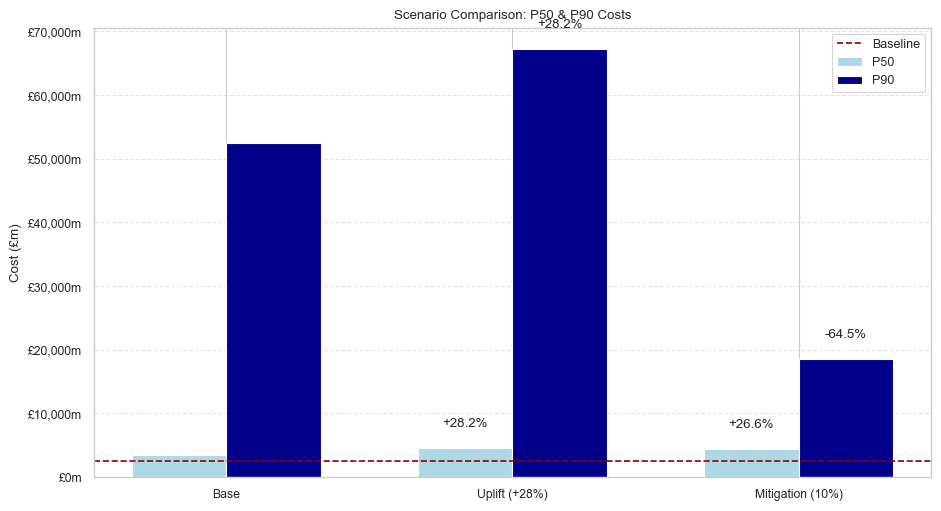

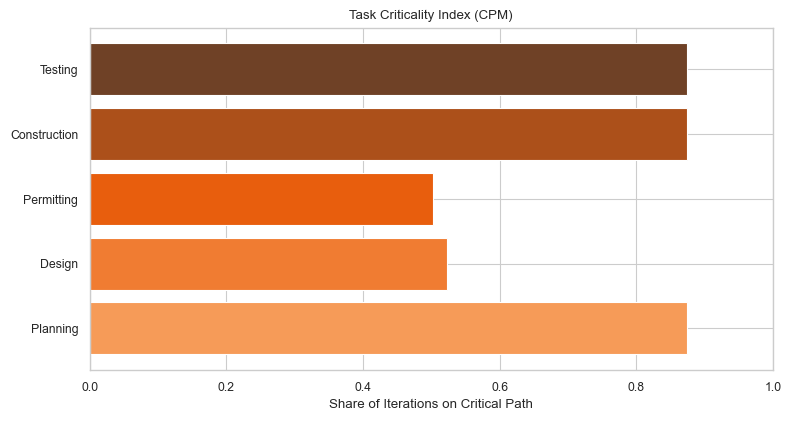

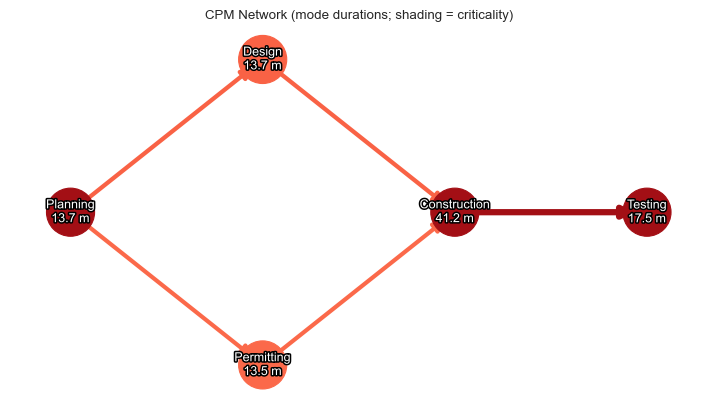

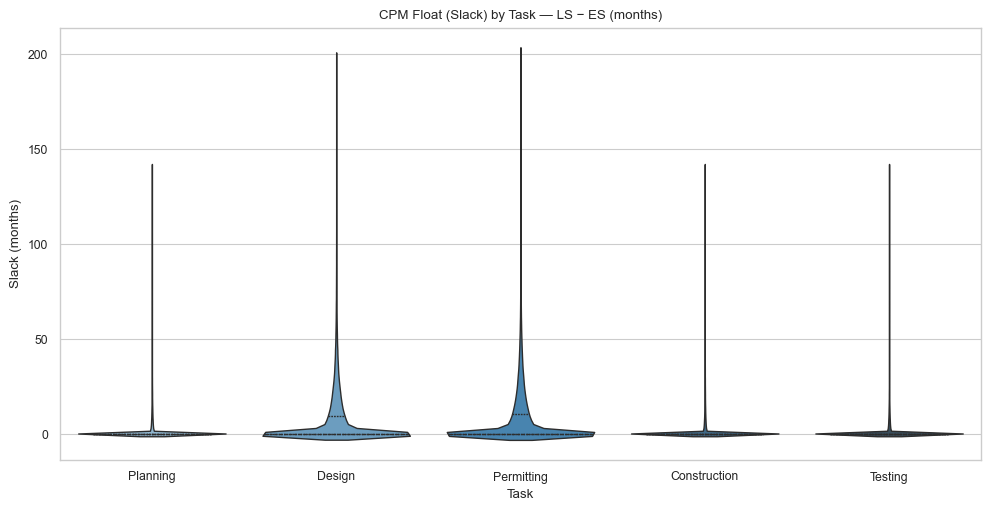

[Saved] cpm_slack_summary.csv

Saved: mcs_summary_table.csv
[Saved] mcs_results.json
[Saved] figure_captions.json, figure_captions.md

Results by Research Question

RQ1 — Key risk drivers contributing to cost overruns and schedule delays
- Projects with usable narratives: 111
 • funding issues: 51 projects (46%)
 • procurement risk: 47 projects (42%)
 • planning delays: 8 projects (7%)
 • technical challenges: 8 projects (7%)
 • scope changes: 7 projects (6%)
- These drivers informed task multipliers: {'Planning': 1.02, 'Design': 1.02, 'Permitting': 1.0, 'Construction': 1.02, 'Testing': 1.14}

RQ2 — Monte Carlo model setup and application
- Iterations: 100,000; CPM enabled: True; PERT enabled: False; Precedence: [('Planning', 'Design'), ('Planning', 'Permitting'), ('Design', 'Construction'), ('Permitting', 'Construction'), ('Construction', 'Testing')]
- Baselines: Duration 86.2 months (CPM on modes); Cost £2,551m
- Cost–delay coupling: 19.4% per extra month beyond task mode
- Overrun s

In [2]:
# MONTE CARLO SIMULATION
import os, re, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.patheffects as pe
from collections import defaultdict, deque
from scipy.stats import triang, truncnorm, gaussian_kde, spearmanr, beta
# ---- Matplotlib colormap compatibility ----
try:
    from matplotlib import colormaps as _mcm
    def get_cmap(name: str):
        return _mcm.get_cmap(name)
except Exception:
    import matplotlib.cm as _cm
    def get_cmap(name: str):
        return _cm.get_cmap(name)
# ----------------------------
# CONFIG
# ----------------------------
sns.set(style="whitegrid", palette="bright", font_scale=1.15)
sns.set_context('paper')
sns.set_palette('muted') # Default muted colors
plt.rcParams['font.family'] = 'sans-serif' # Sans-serif for clean look
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica']
FILE_PATHS = [
    'BEIS_Government_Major_Projects_Portfolio_Data_March_2022.csv',
    'DESNZ_Government_Major_Projects_Portofolio_AR_Data_March_2024.csv',
    'GMPP_Government_Major_Projects_Portfolio_AR_Data_March_2022.csv',
    'GMPP_Government_Major_Projects_Portofolio_AR_Data_March_2023.csv',
    'CO_Government_Major_Projects_Portofolio_AR_Data_March_2024 (1).csv'
]
RNG = np.random.default_rng(42)
N_SIM = 100_000
SAVE_PLOTS = True
PLOT_DPI = 300
POSITIVE_OVERRUNS_ONLY = True
USE_SHRINKAGE_PRIOR = True
PRIOR_MEAN = 0.35
PRIOR_SD = 0.10
PRIOR_STRENGTH = 20
AUTO_PRIOR_STRENGTH = True
USE_CPM = True
CPM_TOLERANCE = 1e-6
SHOW_SIMPLE_HEATMAPS = False
SHOW_TABLES = False
SHOW_APPENDIX_VISUALS = False
USE_PERT = False
CAPTURE_CAPTIONS = True
_CAPTIONS = []
_FIG_INDEX = 1
def _maybe_save(fname):
    if SAVE_PLOTS and fname:
        plt.savefig(fname, dpi=PLOT_DPI, bbox_inches='tight')
def show_save_caption(fname=None, caption=None):
    global _FIG_INDEX
    _maybe_save(fname)
    plt.show()
    plt.close()
    if CAPTURE_CAPTIONS and caption:
        _CAPTIONS.append({"figure": f"Figure {_FIG_INDEX}", "file": fname or "", "caption": caption})
        _FIG_INDEX += 1
# ----------------------------
# LOADING & CLEANING
# ----------------------------
def to_pct(x):
    if pd.isna(x): return np.nan
    m = re.search(r'-?\d+(\.\d+)?', str(x))
    return float(m.group())/100 if m else np.nan
def to_float(x):
    if pd.isna(x): return np.nan
    try:
        return float(str(x).replace(',',''))
    except Exception:
        return np.nan
def load_and_clean(file_path):
    try:
        df = pd.read_csv(file_path, encoding='utf-8')
    except Exception as e:
        print(f"[WARN] {file_path}: {e}")
        return pd.DataFrame()
    if 'Financial Year Variance (%)' in df.columns:
        c = 'Financial Year Variance (%)'
        df[c] = df[c].apply(to_pct)
        df.loc[(df[c] < -0.9) | (df[c] > 5.0), c] = np.nan
    for c in [
        'Financial Year Baseline (£m) (including Non-Government Costs)',
        'Financial Year Forecast (£m) (including Non-Government Costs)',
        'TOTAL Baseline Whole Life Costs (£m) (including Non-Government Costs)',
        'TOTAL Forecast Whole Life Costs (£m) (including Non-Government Costs)',
    ]:
        if c in df.columns:
            df[c] = df[c].apply(to_float)
    return df
# ----------------------------
# DATA-DRIVEN EXTRACTORS (ADDED)
# ----------------------------
DRIVER_LEXICON = {
    "planning delays": [
        r"\bplanning (delay|permission|consent)s?\b",
        r"\bsite selection\b", r"\bland (acquisition|access)\b",
        r"\bstakeholder (opposition|consultation)\b"
    ],
    "regulatory delays": [
        r"\bregulator(y|ies)? (approval|clearance|hold[- ]up)s?\b",
        r"\bpermit(s|ting)?\b", r"\blicen[sc]e\b", r"\benvironmental (impact|assessment)\b"
    ],
    "technical challenges": [
        r"\btechnical (issue|challenge|complexit(y|ies))\b",
        r"\bdesign (change|rework|defect)s?\b", r"\bengineering\b",
        r"\bgeolog(y|ical)\b", r"\bseismic\b", r"\bunforeseen site condition(s)?\b"
    ],
    "funding issues": [
        r"\bfunding (gap|constraint|approval)s?\b", r"\bbudget (cut|pressure)s?\b",
        r"\bspending review\b", r"\baffordability\b"
    ],
    "scope changes": [
        r"\bscope (change|creep|increase)s?\b", r"\brequirements? change(s)?\b",
        r"\bvariation[s]?\b"
    ],
    "procurement risk": [
        r"\bprocurement (delay|issue|challenge)s?\b", r"\btender(ing)?\b",
        r"\bcontract(or)? (performance|dispute|availability)\b",
        r"\bsupply chain\b", r"\blead[- ]time(s)?\b"
    ],
}
def _find_project_name_column(df):
    cand = [
        "Project Name", "Project name", "Project", "Programme/Project",
        "Project or Programme", "Project Title", "Project title"
    ]
    lc = {c.lower(): c for c in df.columns}
    for c in cand:
        if c.lower() in lc:
            return lc[c.lower()]
    for c in df.columns:
        cl = c.lower()
        if "project" in cl or "programme" in cl or "program" in cl:
            return c
    return None
def extract_key_drivers(df):
    """Return {project_name: [driver labels]} based on regex matches in narrative/commentary fields."""
    narr_cols = [c for c in df.columns if any(k in c.lower() for k in ["narrative", "commentary", "comment", "update"])]
    if not narr_cols:
        return {}
    proj_col = _find_project_name_column(df)
    out = {}
    for idx, row in df.iterrows():
        key = None
        if proj_col and pd.notna(row.get(proj_col, None)):
            key = str(row[proj_col]).strip()
        else:
            key = f"Project_{idx}"
        text = " ".join(str(row[c]) for c in narr_cols if pd.notna(row[c])).lower()
        if not text.strip():
            continue
        drivers = []
        for label, patterns in DRIVER_LEXICON.items():
            if any(re.search(p, text, re.I) for p in patterns):
                drivers.append(label)
        if drivers:
            out[key] = sorted(set(drivers))
    return out
def extract_overruns_like_for_like(df):
    """Build like-for-like overrun series from each dataframe.
    Returns a dict possibly containing keys 'wlc_ratio', 'fy_amount_ratio', 'fy_pct_field'.
    """
    out = {}
    # Whole-life overruns
    base_wlc_col = "TOTAL Baseline Whole Life Costs (£m) (including Non-Government Costs)"
    fcst_wlc_col = "TOTAL Forecast Whole Life Costs (£m) (including Non-Government Costs)"
    if base_wlc_col in df.columns and fcst_wlc_col in df.columns:
        b = pd.to_numeric(df[base_wlc_col], errors="coerce")
        f = pd.to_numeric(df[fcst_wlc_col], errors="coerce")
        wlc_ratio = (f / b) - 1.0
        wlc_ratio = wlc_ratio.replace([np.inf, -np.inf], np.nan).dropna()
        wlc_ratio = wlc_ratio[(wlc_ratio > -0.90) & (wlc_ratio < 5.00)]
        if POSITIVE_OVERRUNS_ONLY:
            wlc_ratio = wlc_ratio[wlc_ratio > 0]
        out["wlc_ratio"] = wlc_ratio
    # Financial-year overruns (amounts preferred)
    base_fy_col = "Financial Year Baseline (£m) (including Non-Government Costs)"
    fcst_fy_col = "Financial Year Forecast (£m) (including Non-Government Costs)"
    var_pct_col = "Financial Year Variance (%)"
    if base_fy_col in df.columns and fcst_fy_col in df.columns:
        b = pd.to_numeric(df[base_fy_col], errors="coerce")
        f = pd.to_numeric(df[fcst_fy_col], errors="coerce")
        fy_amount_ratio = (f / b) - 1.0
        fy_amount_ratio = fy_amount_ratio.replace([np.inf, -np.inf], np.nan).dropna()
        fy_amount_ratio = fy_amount_ratio[(fy_amount_ratio > -0.90) & (fy_amount_ratio < 5.00)]
        if POSITIVE_OVERRUNS_ONLY:
            fy_amount_ratio = fy_amount_ratio[fy_amount_ratio > 0]
        out["fy_amount_ratio"] = fy_amount_ratio
    elif var_pct_col in df.columns:
        fy_pct_field = pd.to_numeric(df[var_pct_col], errors="coerce").dropna()
        if POSITIVE_OVERRUNS_ONLY:
            fy_pct_field = fy_pct_field[fy_pct_field > 0]
        out["fy_pct_field"] = fy_pct_field
    return out
# ----------------------------
# DERIVE WBS/CPM FROM DATASETS 
# ----------------------------
def derive_wbs_tasks(dfs, driver_freq, max_uplift=0.30):
    """Derive WBS tasks, CPM edges, and modeling parameters from datasets."""
    wlc_base_col = 'TOTAL Baseline Whole Life Costs (£m) (including Non-Government Costs)'
    wlc_bases = []
    for df in dfs:
        if wlc_base_col in df.columns:
            wlc_bases.extend(df[wlc_base_col].dropna().values)
    avg_wlc = np.mean(wlc_bases) if wlc_bases else 10000.0
    overrun_spread = np.std([x for x in wlc_bases if not np.isnan(x)]) / avg_wlc if wlc_bases else 0.2
    GLOBAL_DUR_SHOCK_SD = overrun_spread / 2
    GLOBAL_COST_SHOCK_SD = overrun_spread
    COST_PER_EXTRA_MONTH = overrun_spread / 10
    # Adjust cost proportions by project type (energy vs. non-energy) via narratives
    energy_keywords = ['geo(log(y|ical)?)?', 'seismic', 'nuclear', 'carbon capture']
    energy_count, total_count = 0, 0
    for df in dfs:
        narrative_cols = [c for c in df.columns if any(k in c.lower() for k in ['narrative', 'commentary'])]
        for _, row in df.iterrows():
            text = " ".join(str(row[c]) for c in narrative_cols if pd.notna(row[c])).lower()
            if any(re.search(k, text) for k in energy_keywords):
                energy_count += 1
            total_count += 1
    energy_proportion = energy_count / max(1, total_count)
    cost_proportions = {
        'Planning': 0.05,
        'Design': 0.15 + 0.05 * energy_proportion,
        'Permitting': 0.02 + 0.03 * energy_proportion,
        'Construction': 0.70 - 0.07 * energy_proportion,
        'Testing': 0.08 - 0.01 * energy_proportion
    }
    total_prop = sum(cost_proportions.values())
    cost_proportions = {k: v / total_prop for k, v in cost_proportions.items()}
    # Convert driver_freq into per-task multipliers
    def rff(key):
        return 1.0 + max_uplift * float(driver_freq.get(key, 0.0))
    driver_severity = {
        'planning delays': driver_freq.get('planning delays', 0.0),
        'regulatory delays': driver_freq.get('regulatory delays', 0.0),
        'technical challenges': driver_freq.get('technical challenges', 0.0),
        'funding issues': driver_freq.get('funding issues', 0.0),
        'scope changes': driver_freq.get('scope changes', 0.0),
        'procurement risk': driver_freq.get('procurement risk', 0.0)
    }
    base_dur = 12.0
    dur_modes = {
        'Planning': base_dur * (1 + 2 * driver_severity['planning delays']),
        'Design': base_dur * (1 + 2 * driver_severity['technical challenges']),
        'Permitting': base_dur * (1 + 2 * driver_severity['regulatory delays']),
        'Construction': base_dur * 3 * (1 + 2 * driver_severity['technical challenges']),
        'Testing': base_dur * (1 + driver_severity['funding issues'])
    }
    tasks = []
    for name in ['Planning', 'Design', 'Permitting', 'Construction', 'Testing']:
        mode_cost = avg_wlc * cost_proportions[name]
        if name in ['Planning', 'Permitting']:
            rf_cost = rff(name.lower() + ' delays')
            rf_dur = rff(name.lower() + ' delays')
        elif name == 'Design':
            rf_cost = rff('technical challenges')
            rf_dur = rff('technical challenges')
        elif name == 'Construction':
            rf_cost = rff('regulatory delays')
            rf_dur = rff('regulatory delays')
        else:
            rf_cost = rff('funding issues')
            rf_dur = rff('funding issues')
        tasks.append({
            'name': name,
            'duration_min': dur_modes[name] * (1 - overrun_spread),
            'duration_mode': dur_modes[name],
            'duration_max': dur_modes[name] * (1 + overrun_spread),
            'cost_min': mode_cost * (1 - overrun_spread),
            'cost_mode': mode_cost,
            'cost_max': mode_cost * (1 + overrun_spread),
            'risk_factor_cost': rf_cost,
            'risk_factor_dur': rf_dur
        })
    # Infer CPM edges from narratives
    driver_pairs = defaultdict(int)
    for df in dfs:
        narrative_cols = [c for c in df.columns if any(k in c.lower() for k in ['narrative', 'commentary'])]
        for _, row in df.iterrows():
            text = " ".join(str(row[c]) for c in narrative_cols if pd.notna(row[c])).lower()
            drivers = set()
            for label, patterns in DRIVER_LEXICON.items():
                if any(re.search(p, text, re.I) for p in patterns):
                    drivers.add(label)
            if 'planning delays' in drivers and 'regulatory delays' in drivers:
                driver_pairs[('Planning', 'Permitting')] += 1
            if 'planning delays' in drivers and 'technical challenges' in drivers:
                driver_pairs[('Planning', 'Design')] += 1
            if 'regulatory delays' in drivers and 'technical challenges' in drivers:
                driver_pairs[('Permitting', 'Construction')] += 1
            if 'technical challenges' in drivers:
                driver_pairs[('Design', 'Construction')] += 1
            if 'technical challenges' in drivers and 'funding issues' in drivers:
                driver_pairs[('Construction', 'Testing')] += 1
    threshold = max(driver_pairs.values(), default=0) * 0.5 if driver_pairs else 0
    cpm_edges = [(u, v) for (u, v), count in driver_pairs.items() if count >= threshold]
    if len(cpm_edges) < 4:
        cpm_edges = [
            ('Planning', 'Design'), ('Planning', 'Permitting'),
            ('Design', 'Construction'), ('Permitting', 'Construction'),
            ('Construction', 'Testing')
        ]
    return tasks, cpm_edges, GLOBAL_DUR_SHOCK_SD, GLOBAL_COST_SHOCK_SD, COST_PER_EXTRA_MONTH
# ----------------------------
# LOAD DATA
# ----------------------------
dfs = [load_and_clean(p) for p in FILE_PATHS if os.path.exists(p)]
dfs = [d for d in dfs if not d.empty]
if not dfs:
    print("[ERROR] No datasets loaded. Check paths."); raise SystemExit
# ----------------------------
# BUILD OVERRUN VECTORS
# ----------------------------
wlc_list, fy_list = [], []
for df in dfs:
    out = extract_overruns_like_for_like(df)
    if 'wlc_ratio' in out: wlc_list.append(out['wlc_ratio'])
    if 'fy_amount_ratio' in out: fy_list.append(out['fy_amount_ratio'])
    elif 'fy_pct_field' in out: fy_list.append(out['fy_pct_field'])
wlc_overruns = pd.concat(wlc_list, ignore_index=True).values if wlc_list else np.array([])
fy_overruns = pd.concat(fy_list, ignore_index=True).values if fy_list else np.array([])
wlc_vec = wlc_overruns if wlc_overruns.size else np.array([])
fy_vec = fy_overruns if fy_overruns.size else np.array([])
raw_overruns = np.concatenate([wlc_vec, fy_vec])
def _auto_prior_strength(n):
    if n >= 15: return 5
    if n >= 10: return 10
    if n >= 5: return 20
    return 40
if AUTO_PRIOR_STRENGTH:
    PRIOR_STRENGTH = _auto_prior_strength(len(raw_overruns))
if wlc_vec.size >= 20:
    overrun_series = wlc_vec; overrun_label = "Whole-life overruns"
elif fy_vec.size >= 20:
    overrun_series = fy_vec; overrun_label = "Financial-year overruns"
else:
    overrun_series = raw_overruns
    overrun_label = f"Empirical (n={len(raw_overruns)}) blended with prior (strength={PRIOR_STRENGTH})"
mean_overrun = float(np.nanmean(overrun_series)) if overrun_series.size else PRIOR_MEAN
std_overrun = float(np.nanstd(overrun_series)) if overrun_series.size > 1 else PRIOR_SD
print(f"Using {overrun_label}: mean={mean_overrun:.2%} | sd={std_overrun:.2%}")
# ----------------------------
# DRIVER EXTRACTION
# ----------------------------
key_drivers = {}
for df in dfs:
    kd = extract_key_drivers(df)
    key_drivers.update(kd)
if key_drivers:
    print("\nRQ1: Sample risk drivers (first 5 projects)")
    for i, (proj, drivers) in enumerate(key_drivers.items()):
        if i >= 5: break
        print(f" - {proj}: {drivers}")
else:
    print("[INFO] No narrative/commentary fields found or no driver terms matched. "
          "Driver visuals & multipliers default to neutral (rf=1.0).")
# Frequency & driver_freq map
driver_counts = {}
for drivers in key_drivers.values():
    for d in drivers:
        driver_counts[d] = driver_counts.get(d, 0) + 1
n_projects = max(1, len(key_drivers))
driver_freq = {k: v/n_projects for k, v in driver_counts.items()}
# ----------------------------
# DERIVE WBS, CPM, & PARAMS
# ----------------------------
tasks, CPM_EDGES, GLOBAL_DUR_SHOCK_SD, GLOBAL_COST_SHOCK_SD, COST_PER_EXTRA_MONTH = derive_wbs_tasks(dfs, driver_freq)
baseline_cost = sum(t['cost_mode'] for t in tasks)
# ----------------------------
# CPM HELPERS
# ----------------------------
def cpm_total_duration_and_criticality(task_names, dur_map, edges):
    succ = defaultdict(list)
    pred = defaultdict(list)
    indeg = defaultdict(int)
    nodes = list(task_names)
    G = {n: set() for n in nodes}
    for u, v in edges:
        G[u].add(v)
    def has_cycle(node, visited, rec_stack):
        visited.add(node)
        rec_stack.add(node)
        for neighbor in G.get(node, []):
            if neighbor not in visited:
                if has_cycle(neighbor, visited, rec_stack):
                    return True
            elif neighbor in rec_stack:
                return True
        rec_stack.remove(node)
        return False
    visited, rec_stack = set(), set()
    cycle_detected = any(has_cycle(n, visited, rec_stack) for n in nodes if n not in visited)
    if cycle_detected:
        print("[WARN] Cycle detected in CPM graph; falling back to sum of durations.")
        total = sum(dur_map.get(n, 0.0) for n in nodes)
        return total, {}, {}, {}, {}, set()
    for u, v in edges:
        succ[u].append(v)
        pred[v].append(u)
        indeg[v] += 1
        indeg.setdefault(u, 0)
    for n in nodes:
        indeg.setdefault(n, 0)
    q = deque([n for n in nodes if indeg[n] == 0])
    topo = []
    while q:
        n = q.popleft()
        topo.append(n)
        for w in succ[n]:
            indeg[w] -= 1
            if indeg[w] == 0:
                q.append(w)
    if len(topo) != len(nodes):
        total = sum(dur_map.get(n, 0.0) for n in nodes)
        return total, {}, {}, {}, {}, set()
    ES, EF = {}, {}
    for n in topo:
        es = max([EF[p] for p in pred[n]] or [0.0])
        ef = es + dur_map.get(n, 0.0)
        ES[n], EF[n] = es, ef
    total_duration = max(EF.values()) if EF else 0.0
    LF, LS = {}, {}
    end_nodes = set(nodes) - set(u for u, _ in edges)
    for n in reversed(topo):
        if n in end_nodes:
            lf = total_duration
        else:
            lf = min([LS[s] for s in succ[n]])
        ls = lf - dur_map.get(n, 0.0)
        LF[n], LS[n] = lf, ls
    crit = set([n for n in nodes if abs(LS[n] - ES[n]) <= CPM_TOLERANCE])
    return total_duration, ES, EF, LS, LF, crit
# Baseline duration on mode durations
task_names = [t['name'] for t in tasks]
mode_map = {t['name']: t['duration_mode'] for t in tasks}
baseline_duration, ES_b, EF_b, LS_b, LF_b, _ = cpm_total_duration_and_criticality(task_names, mode_map, CPM_EDGES)
print("\nRQ2: Model setup")
print(f"- Baseline Duration (CPM on mode durations): {baseline_duration:.1f} months")
print(f"- Baseline Cost: £{baseline_cost}m")
print("- Driver-based multipliers (cost):", {t['name']: round(t['risk_factor_cost'], 3) for t in tasks})
# WBS Baseline Cost Breakdown
fig, ax = plt.subplots(figsize=(10, 5.5))
palette = sns.color_palette('viridis', len(tasks)) # Sequential for phases
ax.barh([t['name'] for t in tasks], [t['cost_mode'] for t in tasks], color=palette)
ax.set_title('WBS Baseline Cost Breakdown')
ax.set_xlabel('Baseline Cost (£m)'); ax.set_ylabel('Task')
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('£{x:,.0f}m'))
for i, v in enumerate([t['cost_mode'] for t in tasks]):
    ax.text(v, i, f" £{v:,.0f}m", va='center', ha='left', color='black', fontsize=10)
ax.grid(axis='x', linestyle='--', alpha=0.5) # Subtle grid
plt.tight_layout()
show_save_caption('rq2_wbs_breakdown.png',
                  'WBS baseline cost by phase, derived from dataset WLCs with narrative-adjusted proportions.')
# CPM ES/LS timeline
fig, ax = plt.subplots(figsize=(10, 4.8))
ypos = np.arange(len(task_names)) * 10
height = 8
for i, name in enumerate(task_names):
    es, ef = ES_b.get(name, 0.0), EF_b.get(name, 0.0)
    ls, lf = LS_b.get(name, 0.0), LF_b.get(name, 0.0)
    dur = ef - es
    ax.broken_barh([(es, dur)], (ypos[i], height), facecolors='steelblue', alpha=0.8, # Muted blue
                   label='Earliest (ES–EF)' if i==0 else None)
    ax.broken_barh([(ls, dur)], (ypos[i], height), facecolors='darkorange', alpha=0.5, # Muted orange
                   label='Latest (LS–LF)' if i==0 else None)
    if ls > ef:
        ax.broken_barh([(ef, ls-ef)], (ypos[i], height), facecolors='lightgray', alpha=0.6,
                       label='Slack' if i==0 else None)
ax.set_yticks(ypos + height/2)
ax.set_yticklabels(task_names)
ax.set_xlabel('Months (baseline CPM on mode durations)')
ax.set_title('CPM Baseline: ES/LS Windows and Slack')
ax.grid(True, axis='x', linestyle='--', alpha=0.3) # Subtle grid
ax.legend(loc='upper right', ncol=3, frameon=True, fontsize=9)
plt.tight_layout()
show_save_caption('cpm_es_ls_timeline.png',
                  'Gantt-like baseline showing earliest (ES–EF), latest (LS–LF) windows, and slack gaps, with edges derived from narrative co-occurrences.')
# ----------------------------
# Overrun sampler
# ----------------------------
def draw_overrun():
    n = len(raw_overruns)
    lo, hi = -0.90, 5.00
    if n == 0:
        a, b = (lo - PRIOR_MEAN)/PRIOR_SD, (hi - PRIOR_MEAN)/PRIOR_SD
        return float(truncnorm.rvs(a, b, loc=PRIOR_MEAN, scale=PRIOR_SD, random_state=RNG))
    if n >= 20:
        return float(RNG.choice(raw_overruns))
    if n >= 1 and USE_SHRINKAGE_PRIOR:
        w = n / (n + PRIOR_STRENGTH)
        if RNG.random() < w:
            return float(RNG.choice(raw_overruns) + RNG.normal(0, 0.01))
        a, b = (lo - PRIOR_MEAN)/PRIOR_SD, (hi - PRIOR_MEAN)/PRIOR_SD
        return float(truncnorm.rvs(a, b, loc=PRIOR_MEAN, scale=PRIOR_SD, random_state=RNG))
    a, b = (lo - PRIOR_MEAN)/PRIOR_SD, (hi - PRIOR_MEAN)/PRIOR_SD
    return float(truncnorm.rvs(a, b, loc=PRIOR_MEAN, scale=PRIOR_SD, random_state=RNG))
# ----------------------------
# Simulation
# ----------------------------
simulated_durations = np.empty(N_SIM)
simulated_costs = np.empty(N_SIM)
task_contrib = {t['name']: {'dur': [], 'cost': []} for t in tasks}
critical_counts = {t['name']: 0 for t in tasks}
edge_keys = [(u, v) for (u, v) in CPM_EDGES]
edge_crit_counts = {e: 0 for e in edge_keys}
slack_samples = {name: [] for name in task_names}
n_tasks = len(tasks)
dur_c = np.array([(t['duration_mode'] - t['duration_min']) / (t['duration_max'] - t['duration_min']) for t in tasks])
dur_loc = np.array([t['duration_min'] for t in tasks])
dur_scale = np.array([t['duration_max'] - t['duration_min'] for t in tasks])
cost_c = np.array([(t['cost_mode'] - t['cost_min']) / (t['cost_max'] - t['cost_min']) for t in tasks])
cost_loc = np.array([t['cost_min'] for t in tasks])
cost_scale = np.array([t['cost_max'] - t['cost_min'] for t in tasks])
rf_dur = np.array([t['risk_factor_dur'] for t in tasks])
rf_cost = np.array([t['risk_factor_cost'] for t in tasks])
dur_modes = np.array([t['duration_mode'] for t in tasks])
for i in range(N_SIM):
    dur_map, cost_map = {}, {}
    g_dur = RNG.normal(0.0, GLOBAL_DUR_SHOCK_SD)
    g_cost = RNG.normal(0.0, GLOBAL_COST_SHOCK_SD)
    if USE_PERT:
        a = 4 * dur_c + 1
        b = 5 - 4 * dur_c
        durs = beta.rvs(a, b, loc=dur_loc, scale=dur_scale, size=n_tasks, random_state=RNG)
        a = 4 * cost_c + 1
        b = 5 - 4 * cost_c
        costs = beta.rvs(a, b, loc=cost_loc, scale=cost_scale, size=n_tasks, random_state=RNG)
    else:
        durs = triang.rvs(c=dur_c, loc=dur_loc, scale=dur_scale, size=n_tasks, random_state=RNG)
        costs = triang.rvs(c=cost_c, loc=cost_loc, scale=cost_scale, size=n_tasks, random_state=RNG)
    durs *= rf_dur * max(0.0, 1.0 + g_dur)
    costs *= rf_cost * max(0.0, 1.0 + g_cost)
    months_over = np.maximum(0.0, durs - dur_modes)
    costs *= (1.0 + COST_PER_EXTRA_MONTH * months_over)
    for task, dur, cost in zip(tasks, durs, costs):
        dur_map[task['name']] = float(dur)
        cost_map[task['name']] = float(cost)
    total_dur, ES, EF, LS, LF, crit = cpm_total_duration_and_criticality(task_names, dur_map, CPM_EDGES)
    for n in crit:
        if n in critical_counts: critical_counts[n] += 1
    for (u, v) in CPM_EDGES:
        if (u in crit) and (v in crit) and (abs(EF.get(u, 0.0) - ES.get(v, 0.0)) <= CPM_TOLERANCE):
            edge_crit_counts[(u, v)] += 1
    for name in task_names:
        if name in ES and name in LS:
            slack_samples[name].append(float(LS[name] - ES[name]))
    total_cost = float(sum(cost_map.values()))
    overrun = draw_overrun()
    total_cost *= (1.0 + overrun)
    simulated_durations[i] = total_dur
    simulated_costs[i] = total_cost
    for name in task_names:
        task_contrib[name]['dur'].append(dur_map[name])
        task_contrib[name]['cost'].append(cost_map[name])
np.savetxt('simulated_durations.csv', simulated_durations, delimiter=',', header='Duration (months)', comments='')
np.savetxt('simulated_costs.csv', simulated_costs, delimiter=',', header='Cost (£m)', comments='')
print("[Saved] simulated_durations.csv and simulated_costs.csv")
criticality_index = {k: critical_counts[k] / N_SIM for k in critical_counts}
edge_criticality_index = {e: edge_crit_counts[e] / N_SIM for e in edge_crit_counts}
if USE_CPM and CPM_EDGES:
    print("\nCriticality Index (CPM) — Tasks:")
    for k, v in criticality_index.items():
        print(f" - {k}: {v:.1%}")
    print("\nCriticality Index (CPM) — Edges:")
    for (u, v), ci in edge_criticality_index.items():
        print(f" - {u} → {v}: {ci:.1%}")
# ----------------------------
# Results
# ----------------------------
prob_delay = float(np.mean(simulated_durations > baseline_duration))
prob_overrun = float(np.mean(simulated_costs > baseline_cost))
mean_duration = float(np.mean(simulated_durations))
mean_cost = float(np.mean(simulated_costs))
pcts = [50, 80, 90, 95]
dur_p = np.percentile(simulated_durations, pcts)
cost_p = np.percentile(simulated_costs, pcts)
prob_overrun_20 = float(np.mean(simulated_costs > baseline_cost * 1.20))
prob_overrun_50 = float(np.mean(simulated_costs > baseline_cost * 1.50))
prob_delay_20   = float(np.mean(simulated_durations > baseline_duration * 1.20))
prob_delay_50   = float(np.mean(simulated_durations > baseline_duration * 1.50))
print("\nRQ3: Likelihood of overruns")
print(f"- Mean Duration: {mean_duration:.2f} months | P90: {dur_p[2]:.2f} | Prob delay: {prob_delay:.2%}")
print(f"- Mean Cost: £{mean_cost:.2f}m | P90: £{cost_p[2]:.2f}m | Prob overrun: {prob_overrun:.2%}")
print(f"- Prob(cost overrun >20%): {prob_overrun_20:.2%}")
print(f"- Prob(cost overrun >50%): {prob_overrun_50:.2%}")
print(f"- Prob(schedule delay >20%): {prob_delay_20:.2%}")
print(f"- Prob(schedule delay >50%): {prob_delay_50:.2%}")
# Adjust ranges: Clip to P1-P99 to reduce outlier impact
dur_p1, dur_p99 = np.percentile(simulated_durations, [1, 99])
cost_p1, cost_p99 = np.percentile(simulated_costs, [1, 99])
fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))
sns.violinplot(y=simulated_durations, ax=axes[0], color='darkgreen', inner=None, alpha=0.7) # Muted green
sns.boxplot(y=simulated_durations, ax=axes[0], width=0.1, color='white', fliersize=0)
axes[0].axhline(baseline_duration, color='darkred', ls='--', label='Baseline')
axes[0].axhline(mean_duration, color='black', ls='-', label=f'Mean {mean_duration:.1f}')
axes[0].set_title('Duration Distribution (Adjusted Range)')
axes[0].set_ylabel('Months')
axes[0].set_ylim(dur_p1 * 0.9, dur_p99 * 1.1)
axes[0].legend(fontsize=9)
sns.violinplot(y=simulated_costs, ax=axes[1], color='navy', inner=None, alpha=0.7) # Muted blue
sns.boxplot(y=simulated_costs, ax=axes[1], width=0.1, color='white', fliersize=0)
axes[1].axhline(baseline_cost, color='darkred', ls='--', label='Baseline')
axes[1].axhline(mean_cost, color='black', ls='-', label=f'Mean £{mean_cost:,.0f}m')
axes[1].yaxis.set_major_formatter(mtick.StrMethodFormatter('£{x:,.0f}m'))
axes[1].set_title('Cost Distribution (Adjusted Range)')
axes[1].set_ylabel('£m')
axes[1].set_ylim(cost_p1 * 0.9, cost_p99 * 1.1)
axes[1].legend(fontsize=9)
plt.tight_layout()
show_save_caption('rq3_violins_adjusted.png',
                  'Violin plots with boxplot overlay of simulated duration and cost (adjusted ranges); dashed lines show baselines and solid lines show means.')
def bootstrap_ecdf_band(x, n_boot=800, alpha=0.05, seed=123):
    x = np.sort(np.asarray(x))
    grid = np.linspace(x.min(), x.max(), 300)
    def ecdf(arr, g): return np.searchsorted(arr, g, side='right')/len(arr)
    base = np.array([ecdf(x, g) for g in grid])
    rngb = np.random.default_rng(seed)
    boots = np.empty((n_boot, grid.size))
    for b in range(n_boot):
        xb = rngb.choice(x, size=len(x), replace=True); xb.sort()
        boots[b,:] = [ecdf(xb, g) for g in grid]
    lo = np.quantile(boots, alpha/2, axis=0)
    hi = np.quantile(boots, 1-alpha/2, axis=0)
    return grid, base, lo, hi
for vals, baseline, label, fname, cap in [
    (simulated_costs, baseline_cost, 'Cost (£m)', 'ecdf_cost.png',
     'ECDF of simulated total cost with 95% bootstrap band; vertical line shows baseline.'),
    (simulated_durations, baseline_duration, 'Duration (months)', 'ecdf_duration.png',
     'ECDF of simulated total duration with 95% bootstrap band; vertical line shows baseline.')
]:
    grid, ecdf_line, lo, hi = bootstrap_ecdf_band(vals)
    plt.figure(figsize=(10,5))
    plt.plot(grid, ecdf_line, label='ECDF', color='black')
    plt.fill_between(grid, lo, hi, alpha=0.2, color='gray', label='95% band') # Muted gray band
    plt.axvline(baseline, ls='--', label='Baseline', color='darkred')
    plt.title(f'ECDF with 95% Bootstrap Band — {label}')
    plt.xlabel(label); plt.ylabel('Cumulative Probability'); plt.legend(fontsize=9)
    if 'Cost' in label:
        plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('£{x:,.0f}m'))
    plt.grid(axis='y', linestyle='--', alpha=0.3) # Subtle grid
    show_save_caption(fname, cap)
# Joint KDE
xmin, xmax = np.percentile(simulated_durations, [5, 95])
ymin, ymax = np.percentile(simulated_costs, [5, 95])
xy = np.vstack([simulated_durations, simulated_costs])
kde = gaussian_kde(xy)
X = np.linspace(xmin, xmax, 220)
Y = np.linspace(ymin, ymax, 220)
XX, YY = np.meshgrid(X, Y)
ZZ = kde(np.vstack([XX.ravel(), YY.ravel()])).reshape(XX.shape)
plt.figure(figsize=(8.5,6.5))
cs = plt.contour(XX, YY, ZZ, levels=8, colors='k', linewidths=0.8)
plt.clabel(cs, inline=True, fontsize=8)
plt.imshow(ZZ, origin='lower', extent=[xmin, xmax, ymin, ymax],
           aspect='auto', alpha=0.4, cmap='Blues') # Muted 'Blues' for publication
plt.axvline(baseline_duration, ls='--', color='darkred')
plt.axhline(baseline_cost, ls='--', color='darkred')
plt.title('Joint Risk Surface (Duration vs Cost) - Adjusted Range')
plt.xlabel('Duration (months)')
plt.ylabel('Cost (£m)')
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('£{x:,.0f}m'))
plt.tight_layout()
show_save_caption('joint_kde_adjusted.png',
                  '2D KDE of duration vs cost with iso-probability contours (adjusted ranges); red lines indicate baselines.')
# Sensitivity
sens_dur, sens_cost = {}, {}
for t in tasks:
    td = np.array(task_contrib[t['name']]['dur'])
    tc = np.array(task_contrib[t['name']]['cost'])
    sens_dur[t['name']] = spearmanr(td, simulated_durations).correlation
    sens_cost[t['name']] = spearmanr(tc, simulated_costs).correlation
sens_df = pd.DataFrame({
    'Task': [t['name'] for t in tasks],
    'Abs Spearman vs Duration': [abs(sens_dur[t['name']]) for t in tasks],
    'Abs Spearman vs Cost': [abs(sens_cost[t['name']]) for t in tasks],
}).sort_values('Abs Spearman vs Cost', ascending=True)
fig, ax = plt.subplots(figsize=(9,5))
palette = sns.color_palette('Blues_d', len(sens_df)) # Darker blues for emphasis
ax.barh(sens_df['Task'], sens_df['Abs Spearman vs Cost'], color=palette)
ax.set_title('Sensitivity (|Spearman|) — Task Cost vs Total Cost')
ax.set_xlabel('Absolute Spearman Correlation')
ax.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
show_save_caption('sensitivity_cost.png',
                  'Absolute Spearman correlations of per-task cost vs total cost (proxy for sensitivity).')
# Task co-movement
data_matrix = pd.DataFrame({t['name']: task_contrib[t['name']]['cost'] for t in tasks})
if not data_matrix.empty:
    corr_matrix = data_matrix.corr(method='spearman')
    if SHOW_SIMPLE_HEATMAPS:
        plt.figure(figsize=(7.5,6))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f") 
        plt.title('Task Cost Co-movement (Spearman)')
        plt.tight_layout()
        show_save_caption('heatmap_tasks.png',
                          'Heatmap of Spearman correlations among per-task costs (co-movement / common shocks).')
    g = sns.clustermap(corr_matrix, cmap='coolwarm', annot=True, vmin=-1, vmax=1, fmt=".2f", metric='euclidean', method='average')
    g.fig.suptitle('Task Cost Co-movement (Spearman) — Clustered', y=1.02)
    if SAVE_PLOTS:
        g.fig.savefig('heatmap_tasks_clustered.png', dpi=PLOT_DPI, bbox_inches='tight')
    plt.show()
    _CAPTIONS.append({"figure": f"Figure {_FIG_INDEX}", "file": 'heatmap_tasks_clustered.png',
                      "caption": "Clustered heatmap of Spearman correlations among per-task costs."})
    _FIG_INDEX += 1
# Scenario analysis
uplift = mean_overrun
cost_base_p50, cost_base_p90 = np.percentile(simulated_costs, [50, 90])
cost_uplift_p50, cost_uplift_p90 = np.percentile(simulated_costs*(1+uplift), [50, 90])
def mitigated_costs(samples=5000, mitigation_level=0.1):
    out = np.empty(samples)
    for i in range(samples):
        tot = 0.0
        for task in tasks:
            dur_c_local = (task['duration_mode'] - task['duration_min']) / (task['duration_max'] - task['duration_min'])
            dur = triang.rvs(c=dur_c_local, loc=task['duration_min'], scale=(task['duration_max'] - task['duration_min']),
                             random_state=RNG) * (task['risk_factor_dur']*(1-mitigation_level))
            cost_c_local = (task['cost_mode'] - task['cost_min']) / (task['cost_max'] - task['cost_min'])
            cost = triang.rvs(c=cost_c_local, loc=task['cost_min'], scale=(task['cost_max'] - task['cost_min']),
                              random_state=RNG) * (task['risk_factor_cost']*(1-mitigation_level))
            months_over_local = max(0.0, dur - task['duration_mode'])
            cost *= (1.0 + (COST_PER_EXTRA_MONTH * (1-mitigation_level)) * months_over_local)
            tot += cost
        tot *= (1.0 + draw_overrun())
        out[i] = tot
    return out
mit = mitigated_costs()
cost_mit_p50, cost_mit_p90 = np.percentile(mit, [50, 90])
labels = ['Base', f'Uplift (+{uplift*100:.0f}%)', 'Mitigation (10%)']
p50s = [cost_base_p50, cost_uplift_p50, cost_mit_p50]
p90s = [cost_base_p90, cost_uplift_p90, cost_mit_p90]
x = np.arange(len(labels)); w = 0.33
plt.figure(figsize=(9.5,5.2))
plt.bar(x - w/2, p50s, width=w, label='P50', color='lightblue')
plt.bar(x + w/2, p90s, width=w, label='P90', color='darkblue')
plt.axhline(baseline_cost, ls='--', color='darkred', label='Baseline')
plt.xticks(x, labels); plt.ylabel('Cost (£m)')
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('£{x:,.0f}m'))
plt.title('Scenario Comparison: P50 & P90 Costs'); plt.legend(fontsize=9)
def _pct(a, b):
    return (b - a)/a if a else np.nan
for i, (p50, p90) in enumerate(zip(p50s, p90s)):
    if i == 0: continue
    ymax = max(p90s)
    plt.annotate(f"{_pct(p50s[0], p50):+.1%}",
                 xy=(x[i]-w/2, p50), xytext=(x[i]-w/2, p50 + 0.05*ymax),
                 ha='center', arrowprops=dict(arrowstyle='->', lw=1))
    plt.annotate(f"{_pct(p90s[0], p90):+.1%}",
                 xy=(x[i]+w/2, p90), xytext=(x[i]+w/2, p90 + 0.05*ymax),
                 ha='center', arrowprops=dict(arrowstyle='->', lw=1))
plt.grid(axis='y', linestyle='--', alpha=0.5) 
plt.tight_layout()
show_save_caption('scenario_waterfall.png',
                  'Scenario comparison of P50 and P90 costs with percentage deltas vs Base; dashed line is baseline.')
# CPM criticality bar
plt.figure(figsize=(8.0,4.3))
names = list(criticality_index.keys())
vals = [criticality_index[n] for n in names]
plt.barh(names, vals, color=sns.color_palette('Oranges_d', len(names))) 
plt.title('Task Criticality Index (CPM)')
plt.xlabel('Share of Iterations on Critical Path')
plt.xlim(0,1)
plt.tight_layout()
show_save_caption('cpm_criticality.png',
                  'Criticality index by task: share of iterations where the task lies on the critical path.')
# Optional network diagram
def draw_cpm_network(tasks, edges, criticality_index, edge_crit_index=None, fname='cpm_network.png'):
    try:
        import networkx as nx
    except ImportError:
        print("[WARN] networkx not installed; drawing simple CPM diagram. Install networkx for better visuals.")
        names = [t['name'] for t in tasks]
        modes = {t['name']: t['duration_mode'] for t in tasks}
        crit_task = {n: criticality_index.get(n, 0.0) for n in names}
        cmap = get_cmap('Reds')
        succ = defaultdict(list); indeg = defaultdict(int)
        for u, v in edges:
            succ[u].append(v); indeg[v]+=1; indeg.setdefault(u,0)
        order = []
        pool = [n for n in names if indeg[n]==0]
        while pool:
            n = pool.pop(0); order.append(n)
            for w in succ[n]:
                indeg[w]-=1
                if indeg[w]==0: pool.append(w)
        if len(order) != len(names): order = names
        x_gap, y = 1.8, 0.5
        plt.figure(figsize=(1.8*len(order)+1, 3))
        ax = plt.gca(); ax.axis('off')
        for i, n in enumerate(order):
            x = i*x_gap
            c = cmap(np.clip(crit_task[n], 0, 1))
            rect = plt.Rectangle((x, y), 1.4, 0.6, facecolor=c, edgecolor='k', lw=1.2)
            ax.add_patch(rect)
            ax.text(x+0.7, y+0.35, f"{n}\n{modes[n]:.1f} m", ha='center', va='center', fontsize=9,
                    color='white', path_effects=[pe.withStroke(linewidth=2.2, foreground='black')])
        centers = {n: (order.index(n)*x_gap+1.4, y+0.3) for n in order}
        for u, v in edges:
            if u in centers and v in centers:
                x1,y1 = centers[u]; x2,y2 = centers[v]
                ci = 0.0 if edge_crit_index is None else edge_crit_index.get((u, v), 0.0)
                arrowprops = dict(arrowstyle='-|>', lw=1.0 + 4.0*ci, color=cmap(np.clip(ci, 0.0, 1.0)))
                ax.annotate("", xy=(x2-1.4, y2), xytext=(x1, y1), arrowprops=arrowprops)
        plt.title('CPM Network (mode durations; shading = criticality)')
        _maybe_save(fname); plt.show(); plt.close()
        return
    G = nx.DiGraph()
    for t in tasks:
        G.add_node(t['name'], mode=t['duration_mode'], crit=criticality_index.get(t['name'], 0.0))
    for u, v in edges: G.add_edge(u, v)
    pred = {n: [p for p, q in edges if q == n] for n in G.nodes()}
    level = {}
    def lvl(n):
        if n in level: return level[n]
        if not pred[n]: level[n] = 0
        else: level[n] = 1 + max(lvl(p) for p in pred[n])
        return level[n]
    for n in G.nodes(): lvl(n)
    levels = {}
    for n, L in level.items():
        levels.setdefault(L, []).append(n)
    pos = {}
    for L, nodes in levels.items():
        nodes_sorted = sorted(nodes)
        ys = np.linspace(0, 1, len(nodes_sorted)+2)[1:-1]
        for y, n in zip(ys, nodes_sorted):
            pos[n] = (L, 1 - y)
    n_cmap = get_cmap('Reds')
    node_colors = [n_cmap(np.clip(G.nodes[n]['crit'], 0.0, 1.0)) for n in G.nodes()]
    e_cmap = get_cmap('Reds')
    edge_colors, edge_widths = [], []
    for (u, v) in G.edges():
        ci = 0.0 if edge_crit_index is None else edge_crit_index.get((u, v), 0.0)
        edge_colors.append(e_cmap(np.clip(ci, 0.0, 1.0)))
        edge_widths.append(1.0 + 4.0*ci)
    plt.figure(figsize=(9, 4.8))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1200)
    nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='-|>', arrowsize=16,
                           width=edge_widths, edge_color=edge_colors)
    labels = {n: f"{n}\n{G.nodes[n]['mode']:.1f} m" for n in G.nodes()}
    txts = nx.draw_networkx_labels(G, pos, labels=labels, font_size=9, font_color='white')
    for t in txts.values():
        t.set_path_effects([pe.withStroke(linewidth=2.2, foreground='black')])
    plt.axis('off'); plt.title('CPM Network (mode durations; shading = criticality)')
    _maybe_save(fname); plt.show(); plt.close()
draw_cpm_network(tasks, CPM_EDGES, criticality_index, edge_crit_index=edge_criticality_index, fname='cpm_network.png')
_CAPTIONS.append({
    "figure": f"Figure {_FIG_INDEX}",
    "file": 'cpm_network.png',
    "caption": "CPM network diagram: node shade = task criticality; edge shade & thickness = edge criticality. Labels show narrative-derived mode durations."
})
_FIG_INDEX += 1
# Slack metrics
slack_df = pd.DataFrame(slack_samples)
if not slack_df.empty:
    plt.figure(figsize=(10, 5.2))
    sns.violinplot(data=slack_df, inner='quartile', palette='Blues_d') 
    plt.title('CPM Float (Slack) by Task — LS − ES (months)')
    plt.ylabel('Slack (months)'); plt.xlabel('Task')
    plt.tight_layout()
    show_save_caption('cpm_slack_violin.png',
                      'Distribution of CPM slack (LS–ES) in months by task across simulations.')
    slack_summary = pd.DataFrame({
        'mean': slack_df.mean(),
        'p10': slack_df.quantile(0.10),
        'p90': slack_df.quantile(0.90)
    })
    slack_summary.to_csv('cpm_slack_summary.csv')
    print("[Saved] cpm_slack_summary.csv")
# Summary table & results JSON
summary = pd.DataFrame({
    'percentile': pcts,
    'duration_months': dur_p,
    'duration_contingency_vs_baseline': dur_p - baseline_duration,
    'cost_millions': cost_p,
    'cost_contingency_vs_baseline': cost_p - baseline_cost
})
summary.to_csv('mcs_summary_table.csv', index=False)
print("\nSaved: mcs_summary_table.csv")
results_json = {
    "config": {
        "n_simulations": int(N_SIM),
        "rng_seed": 42,
        "cost_per_extra_month": float(COST_PER_EXTRA_MONTH),
        "positive_overruns_only": POSITIVE_OVERRUNS_ONLY,
        "overrun_source": overrun_label,
        "use_cpm": USE_CPM,
        "use_pert": USE_PERT,
        "save_plots": SAVE_PLOTS,
        "global_shocks": {"duration_sd": float(GLOBAL_DUR_SHOCK_SD), "cost_sd": float(GLOBAL_COST_SHOCK_SD)}
    },
    "baselines": {
        "duration_months": float(baseline_duration),
        "cost_millions": float(baseline_cost)
    },
    "overruns": {
        "empirical_count": int(len(raw_overruns)),
        "mean_empirical": float(mean_overrun),
        "sd_empirical": float(std_overrun),
        "prior": {"mean": PRIOR_MEAN, "sd": PRIOR_SD, "strength": PRIOR_STRENGTH}
    },
    "duration": {
        "mean": float(mean_duration),
        "percentiles": {str(p): float(v) for p, v in zip([50,80,90,95], dur_p)},
        "prob_delay_vs_baseline": float(prob_delay)
    },
    "cost": {
        "mean": float(mean_cost),
        "percentiles": {str(p): float(v) for p, v in zip([50,80,90,95], cost_p)},
        "prob_overrun_vs_baseline": float(prob_overrun)
    },
    "sensitivity": {
        "spearman_vs_duration": {t['name']: float(sens_dur[t['name']]) for t in tasks},
        "spearman_vs_cost": {t['name']: float(sens_cost[t['name']]) for t in tasks}
    },
    "cpm": {
        "edges": CPM_EDGES,
        "criticality_index_tasks": {k: float(v) for k, v in criticality_index.items()},
        "criticality_index_edges": {f"{u}->{v}": float(ci) for (u, v), ci in edge_criticality_index.items()}
    }
}
with open('mcs_results.json', 'w') as f:
    json.dump(results_json, f, indent=2)
print("[Saved] mcs_results.json")
if CAPTURE_CAPTIONS and _CAPTIONS:
    with open('figure_captions.json', 'w') as f:
        json.dump(_CAPTIONS, f, indent=2)
    with open('figure_captions.md', 'w') as f:
        for c in _CAPTIONS:
            f.write(f"{c['figure']}: {c['caption']} ({c['file']})\n")
    print("[Saved] figure_captions.json, figure_captions.md")
def _money(x): return f"£{x:,.0f}m"
def _months(x): return f"{x:.1f} months"
print("\n" + "="*78)
print("Results by Research Question")
print("="*78)
print("\nRQ1 — Key risk drivers contributing to cost overruns and schedule delays")
n_narr = len(key_drivers)
if n_narr:
    print(f"- Projects with usable narratives: {n_narr}")
    top_drivers = sorted(driver_counts.items(), key=lambda kv: kv[1], reverse=True)[:5]
    for d, c in top_drivers:
        share = c / max(1, n_projects)
        print(f" • {d}: {c} projects ({share:.0%})")
    print("- These drivers informed task multipliers:", {t['name']: round(t['risk_factor_cost'], 2) for t in tasks})
else:
    print("- No narrative-derived drivers detected; model used neutral risk factors (rf = 1.0).")
print("\nRQ2 — Monte Carlo model setup and application")
print(f"- Iterations: {N_SIM:,}; CPM enabled: {USE_CPM}; PERT enabled: {USE_PERT}; Precedence: {CPM_EDGES}")
print(f"- Baselines: Duration {_months(baseline_duration)} (CPM on modes); Cost {_money(baseline_cost)}")
print(f"- Cost–delay coupling: {COST_PER_EXTRA_MONTH*100:.1f}% per extra month beyond task mode")
print(f"- Overrun sampling: {overrun_label}; prior mean {PRIOR_MEAN:.0%}, sd {PRIOR_SD:.0%}, strength {PRIOR_STRENGTH}")
print("\nRQ3 — Likelihood of cost and schedule overruns")
print(f"- Schedule: mean {_months(mean_duration)}, P90 {_months(np.percentile(simulated_durations, 90))}, "
      f"P(delay vs baseline) {prob_delay:.1%}")
print(f"- Cost: mean {_money(mean_cost)}, P90 {_money(np.percentile(simulated_costs, 90))}, "
      f"P(overrun vs baseline) {prob_overrun:.1%}")
print("\nRQ4 — Contingency allowances for confidence levels")
for p, d, c in zip(pcts, dur_p, cost_p):
    d_delta = d - baseline_duration
    c_delta = c - baseline_cost
    sign = "+" if d_delta >= 0 else ""
    print(f"- P{p}: Δtime {sign}{d_delta:.1f} months; Δcost {_money(c_delta)} "
          f"(Duration {_months(d)}, Cost {_money(c)})")
print("\nRQ5 — Mitigation strategies and policy decisions")
top_sens = sorted(((k, abs(v)) for k, v in sens_cost.items()), key=lambda kv: kv[1], reverse=True)[:3]
print("- Highest cost-sensitivity tasks (|Spearman| with total cost):")
for k, v in top_sens:
    print(f" • {k}: |ρ|={v:.2f}")
top_crit_tasks = sorted(criticality_index.items(), key=lambda kv: kv[1], reverse=True)[:3]
print("- Highest criticality tasks (share of iterations on critical path):")
for k, v in top_crit_tasks:
    print(f" • {k}: {v:.0%}")
top_crit_edges = sorted(edge_criticality_index.items(), key=lambda kv: kv[1], reverse=True)[:3]
print("- Highest criticality edges:")
for (u, v), ci in top_crit_edges:
    print(f" • {u} → {v}: {ci:.0%}")
print("- Mitigation scenario (10% risk-factor & coupling reduction):")
print(f" • Cost P50: base {_money(cost_base_p50)} → mitigated {_money(cost_mit_p50)} "
      f"(Δ {_money(cost_mit_p50 - cost_base_p50)})")
print(f" • Cost P90: base {_money(cost_base_p90)} → mitigated {_money(cost_mit_p90)} "
      f"(Δ {_money(cost_mit_p90 - cost_base_p90)})")
print("="*78 + "\n")